<font size="6" font face="Berlin Sans FB" color="#142929"> Project --> Quora Questions Pair Similarity</font>

<font size="4" font face="Berlin Sans FB" color="D42929"> importing libraries</font>

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import datetime
%matplotlib inline

from subprocess import check_output
import gc
import re
import distance
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
#plotly related libraries:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
import plotly.tools as tls

#plt.yscale('log', nonposy='clip')
#!pip install distance --upgrade

<font size="6" font face="Berlin Sans FB" color="D42929"> EDA</font>

<font size="4" font face="Berlin Sans FB" color="A55559"> loading Train.csv file</font>

In [2]:
df = pd.read_csv("train.csv")
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [3]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [4]:
len(df), df.isnull().sum(), df.is_duplicate.value_counts()

(404290, id              0
 qid1            0
 qid2            0
 question1       1
 question2       2
 is_duplicate    0
 dtype: int64, 0    255027
 1    149263
 Name: is_duplicate, dtype: int64)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<font size="4" font face="Berlin Sans FB" color="D42929"> Disribution of data</font>



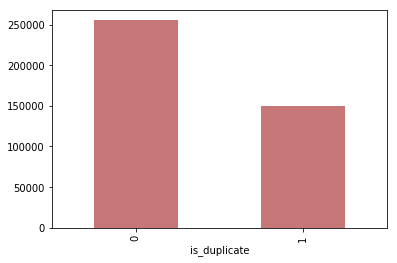

In [6]:
df.groupby('is_duplicate')['id'].count().plot.bar(color="#C77777")

In [7]:
##percent if son similar questions in dataset.
print(np.round(df['is_duplicate'].value_counts()[0] / len(df), 2))

0.63


<font size="4" font face="Berlin Sans FB" color="D42929"> No of Unique Questions</font>


In [8]:
ques_uniq = pd.concat([df.qid1, df.qid2], axis=0).nunique()
ques_repeat = sum(pd.concat([df.qid1, df.qid2], axis=0).value_counts() > 1)
ques_max = sum(pd.concat([df.qid1, df.qid2], axis=0).value_counts().head(1))

print('Unique question counts = {}\nRepeated Question counts = {}\nMaximum quesion asked count = {}'.format(ques_uniq, ques_repeat,ques_max ))


Unique question counts = 537933
Repeated Question counts = 111780
Maximum quesion asked count = 157


<font size="4" font face="Berlin Sans FB" color="D42929">plotting unique questions vs. repeated question</font>



Text(0.5, 1.0, 'Unique Vs total questions plot')

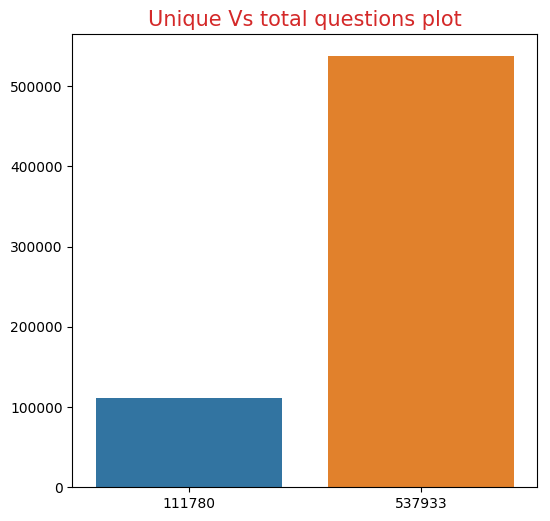

In [9]:
plt.figure(figsize=(6, 6), dpi=100)

sns.barplot([ques_uniq, ques_repeat], [ques_uniq, ques_repeat])
plt.title('Unique Vs total questions plot', color='#D42929', size=15)

<font size="4" font face="Berlin Sans FB" color="D42929">finding duplicate rows</font>



In [10]:
duplicate_rows_df = pd.concat([df.qid1, df.qid2], axis=1).duplicated(subset=['qid1', 'qid2'])
len(duplicate_rows_df)

#conclusion: there's no duplicate rows found since the length of the dataframe equals to the the length of the original df.

404290

<font size="4" font face="Berlin Sans FB" color="D42929">Null values checks and replacement</font>



In [11]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

#filling NA values
print('\n' * 2)
df = df.fillna('Filling Null Values')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  



Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [12]:
len(df)

404290

<font size="4" font face="Berlin Sans FB" color="D42929">Plotting</font>

Maximum number of times a single question is repeated: 157



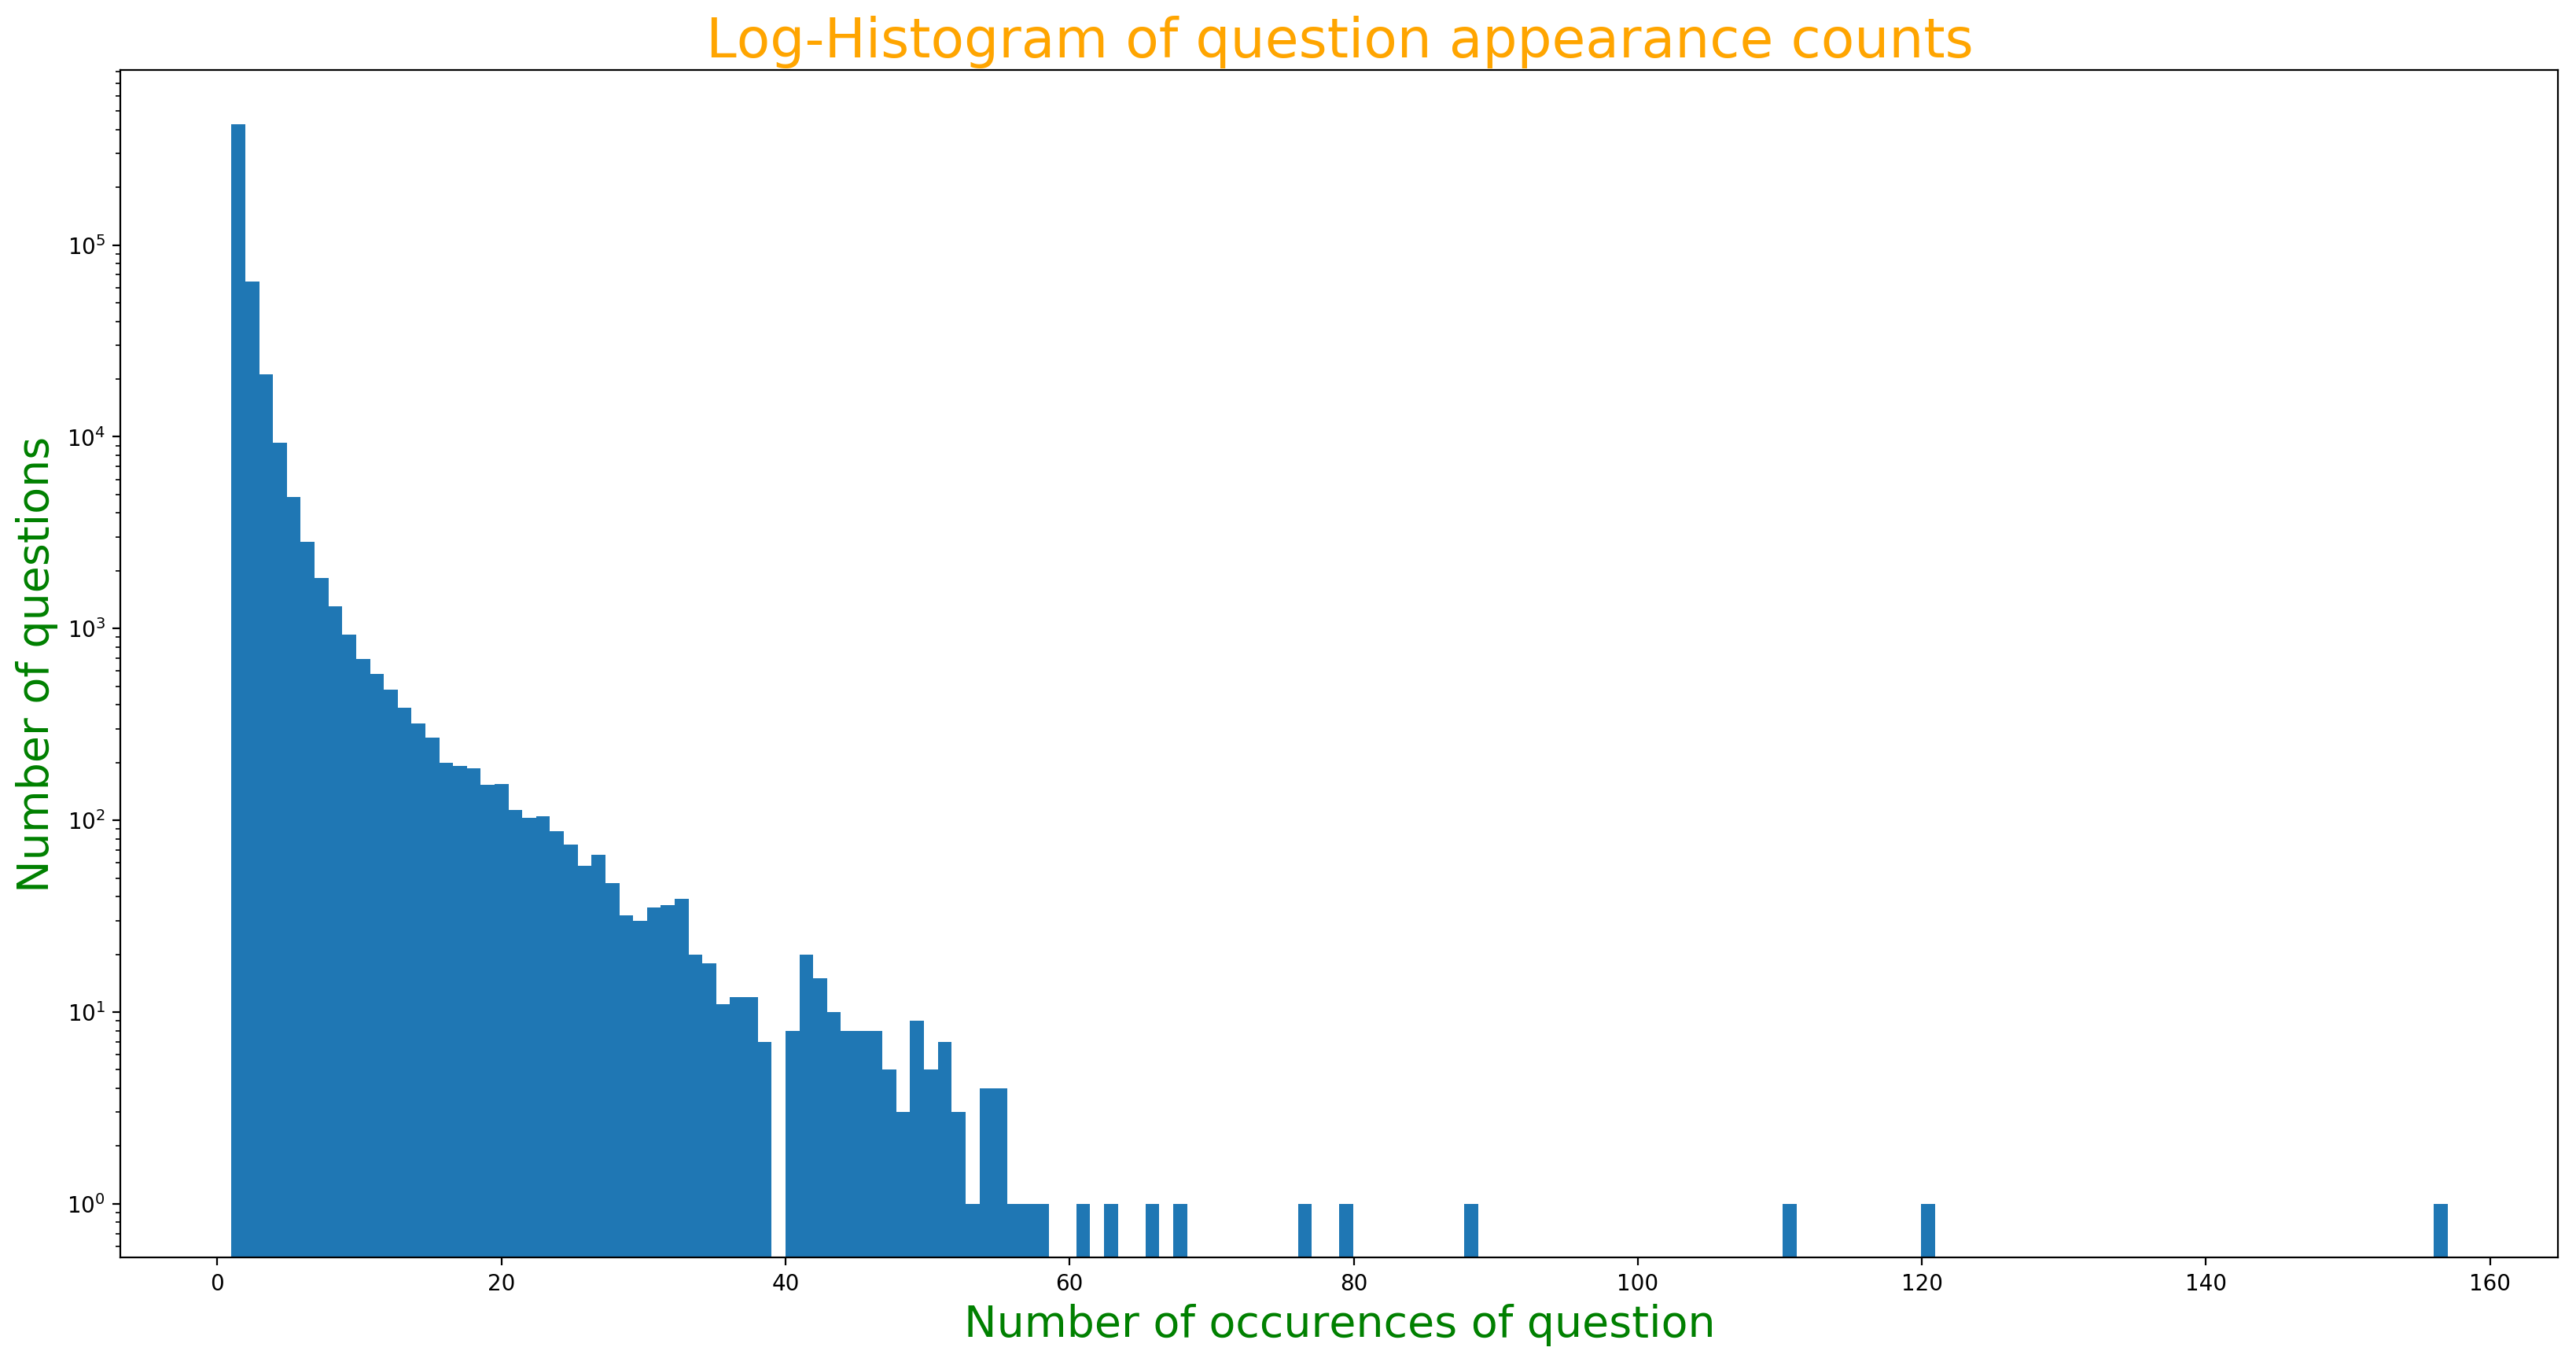

In [13]:
plt.figure(figsize=(20, 10), dpi=200)
plt.hist(pd.concat([df.qid1, df.qid2], axis=0).value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts', color='orange', size=25)
plt.xlabel('Number of occurences of question', size=20, color='green')
plt.ylabel('Number of questions', size=20, color='green')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(pd.concat([df.qid1, df.qid2], axis=0).value_counts()))) 

<font size="6" font face="Berlin Sans FB" color="D42929">Functional Approach --Basic Feature Extraction (before cleaning)</font>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [14]:
def basic_feature_extraction(*args: 'variable number of arguments'):
    '''doing the basic feature extraction technique using column engineering and  
       making into set of new columns
    '''
    global df
    
    #def common_word_count(w1, w2):
        #w1 = w1.strip('\n').split()
        #w2 = w2.strip('\n').split()
        #common_word = 0
        #tmp = w1 if len(w1) > len(w2) else w2
        #for words in tmp:
            #if (words in w1) & (words in w2):
                #common_word += 1
            #else:
                #continue
        #return common_word
            
    
    df['freq_qid1']       = df.groupby(args[0])[args[0]].transform('count')
    df['freq_qid2']       = df.groupby(args[1])[args[1]].transform('count')
    df['q1len']           = df[args[2]].apply(lambda x: len(x))
    df['q2len']           = df[args[3]].apply(lambda x: len(x))
    df['q1_n_words']      = df[args[2]].apply(lambda x: len(x.split()))
    df['q2_n_words']      = df[args[3]].apply(lambda x: len(x.split()))
    df['word_overlap']    = [set(x[3].strip('\n').lower().split()) & set(x[4].strip('\n').lower().split()) for x in df.values]
    df['word_common']     = df['word_overlap'].str.len()
    df['word_total']      = df[args[2]].apply(lambda x: len(x.strip('\n').split())) + df[args[3]].apply(lambda x: len(x.strip('\n').split()))
    df['word_share']      = df['word_common'] / df['word_total']
    df['freq_q1+freq_q2'] = df['freq_qid1'] + df['freq_qid2']
    df['freq_q1-freq_q2'] = np.abs(df['freq_qid1'] - df['freq_qid2'])    
    df.drop('word_overlap', axis=1, inplace=True)
    
    return df                                  
   

In [15]:
%%time
df = basic_feature_extraction('qid1', 'qid2', 'question1', 'question2')

CPU times: user 6.4 s, sys: 392 ms, total: 6.8 s
Wall time: 6.79 s


In [16]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_common', 'word_total', 'word_share', 'freq_q1+freq_q2',
       'freq_q1-freq_q2'],
      dtype='object')

In [16]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+freq_q2,freq_q1-freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10,26,0.384615,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21,0.190476,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,24,0.166667,2,0


<font size="4" font face="Berlin Sans FB" color="D42929">Plotting - Distribution of word_share column</font>

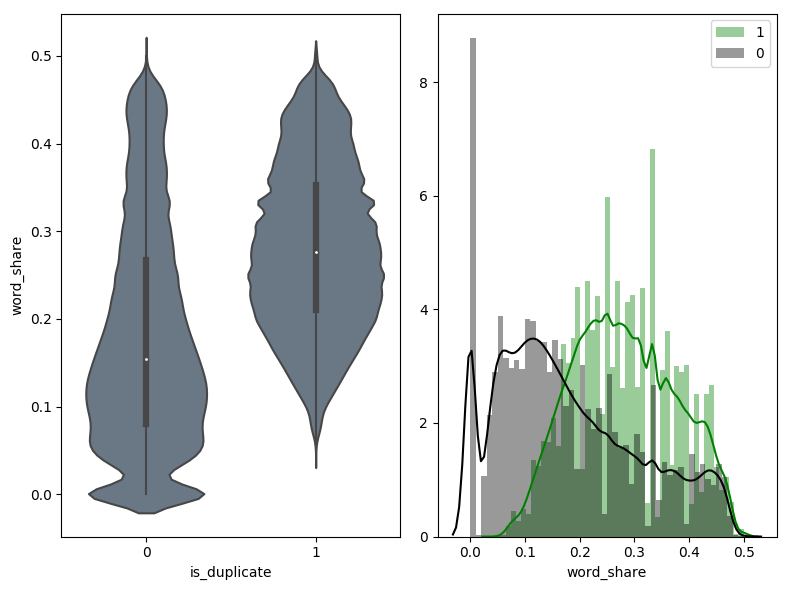

In [17]:
fig = plt.subplots(figsize=(8,6), dpi=100)
plt.subplot(121)
sns.violinplot(x='is_duplicate', y='word_share', data=df, color='#667788')

#plot2:
plt.subplot(122)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'] , label = "1", color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'] , label = "0" , color = 'black')
plt.tight_layout()
plt.legend()
plt.show()

**As we can see from above the column word_share has some importance as the labels are neither perfectly overlapping nor completely noon overlapping..we will see it later**

<font size="4" font face="Berlin Sans FB" color="D42929">Plotting - Distribution of word_common column</font>

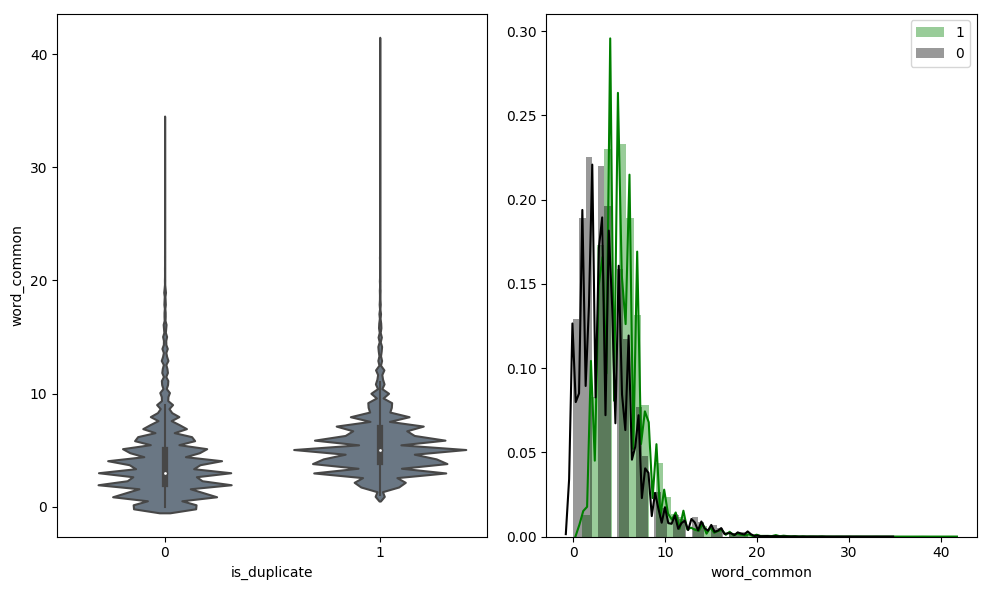

In [18]:
fig = plt.subplots(figsize=(10,6), dpi=100)
plt.subplot(121)
sns.violinplot(x='is_duplicate', y='word_common', data=df, color='#667788')

#plot2:
plt.subplot(122)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_common'] , label = "1", color = 'green')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_common'] , label = "0" , color = 'black')
plt.tight_layout()
plt.legend()
plt.show()

**we could see that the word common feature is not as good as word_share feature as there are multiple overlaps seen in it**

<font size="4" font face="Berlin Sans FB" color="D42929"> HEATMAP -To check collereation values</font>

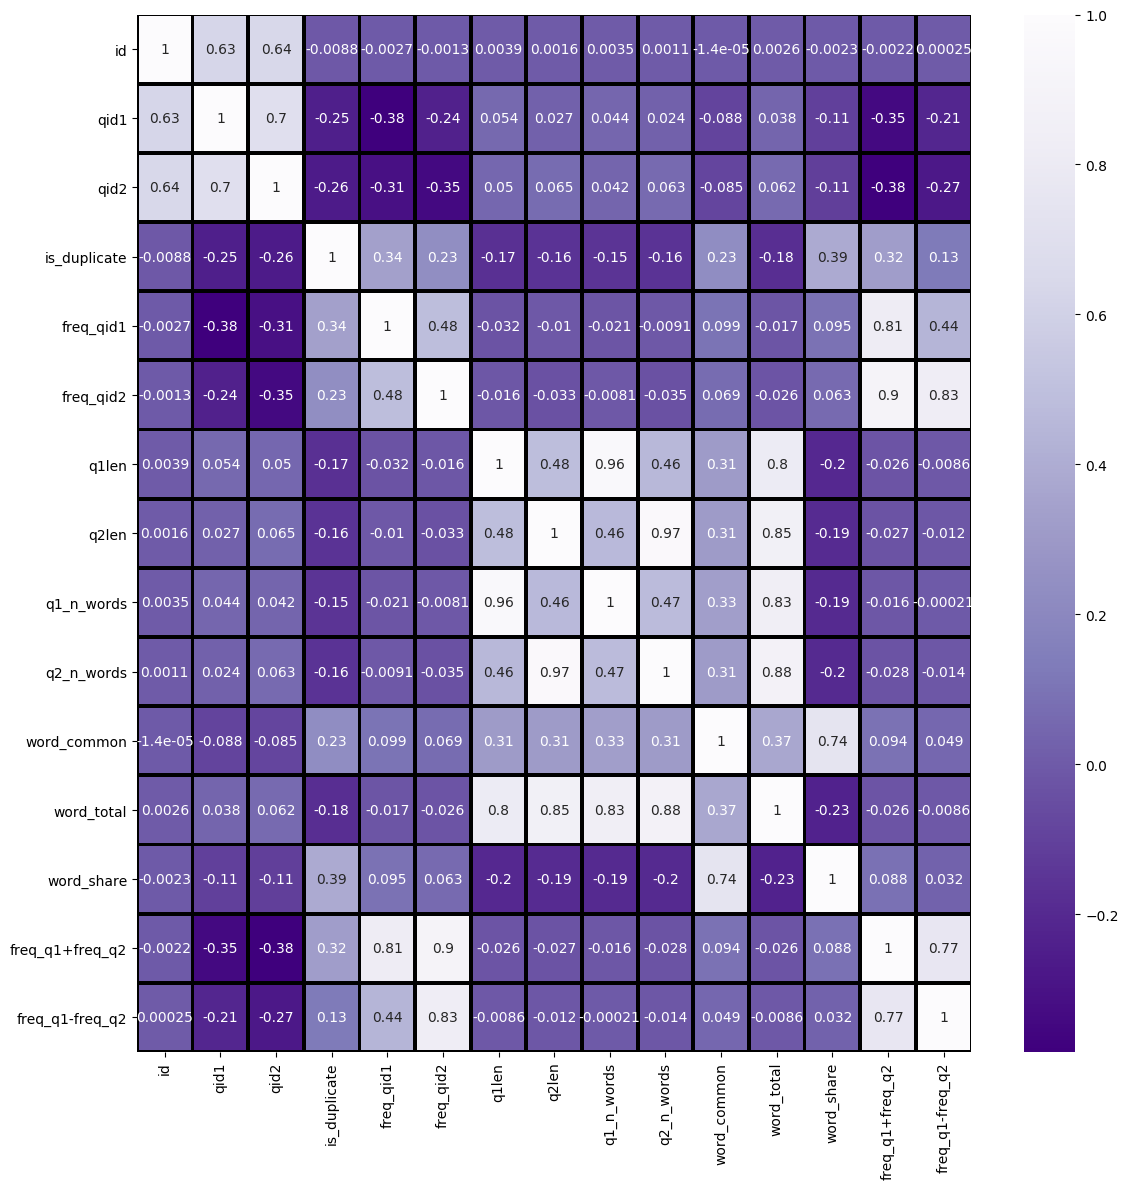

In [19]:
plt.figure(figsize=(12,12), dpi=100)
sns.heatmap(df.corr(), annot=True, linecolor='black', linewidth=2, cmap='Purples_r')
plt.tight_layout()

<font size="6" font face="Berlin Sans FB" color="D42929"> EDA- Advanced Feature extraction</font>

<font size="4" font face="Berlin Sans FB" color="A52678"> Preliminary Preprocessing Text </font>

##### `1. Removal HTML tags through Beautiful soap`

## `2. Lemmatization, removal of punctuation and removal of stopwords using SPACY`

In [20]:
import spacy
from bs4 import BeautifulSoup
import string


nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('spacy stop words lists are: {}'.format(len(stopwords)))



#defining function  using spacy 
def preprocessing(x, stopwords=stopwords):
    
    #basic replacement and preprocessing:
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    #removing HTML, Punctuation( I am using string module) and LEMMATIZATION( using SPACY module)
    if type(x) == type(''):
        example1 = BeautifulSoup(x)    
        x = example1.get_text()
    
    
    list_ = []
    
    for token in nlp(x):
        
        if token.lemma_ == '-PRON-':
            continue
        if token.is_punct:
            continue
        #if token.text in stopwords:
            #continue        
        else:
            list_.append(token.lemma_)
        
    x = ' '.join(list_)       
                
    return x  

spacy stop words lists are: 326


In [21]:
df[df['question1'] == True]
df[df['question2'] == True]
df.reset_index(drop=True, inplace=True)
len(df)

404290

## `Advanced Feature Extraction (NLP and Fuzzy Features)`

In [22]:
%%time

SAFE_DIV = 0.0001
from fuzzywuzzy import fuzz

q1_tokens = df['question1'].apply(lambda x: preprocessing(x))
q2_tokens = df['question2'].apply(lambda x: preprocessing(x))

q1_tokens = q1_tokens.apply(lambda x: x.split())
q2_tokens = q2_tokens.apply(lambda x: x.split())

print(len(q1_tokens), len(q2_tokens))

q1_words = q1_tokens.apply(lambda x: set([arg for arg in x if arg not in stopwords]))
q2_words = q2_tokens.apply(lambda x: set([arg for arg in x if arg not in stopwords]))

print(len(q1_words), len(q2_words))


q1_stops = q1_tokens.apply(lambda x: set([arg for arg in x if arg in stopwords]))
q2_stops = q2_tokens.apply(lambda x: set([arg for arg in x if arg in stopwords]))

print(len(q1_stops), len(q2_stops))


common_word_count = [len(q1_words[i].intersection(q2_words[i])) for i in df.index]
print(len(common_word_count))

common_stop_count = [len(q1_stops[i].intersection(q2_stops[i])) for i in df.index]
print(len(common_stop_count))

common_token_count = [len(set(q1_tokens[i]).intersection(set(q2_tokens[i]))) for i in df.index]
print(len(common_token_count))


df['cwc_min']               = [common_word_count[i] / (min(len(list(q1_words[i])), len(list(q2_words[i]))) + SAFE_DIV) for i in df.index]
df['cwc_max']               = [common_word_count[i] / (max(len(list(q1_words[i])), len(list(q2_words[i]))) + SAFE_DIV) for i in df.index]
df['csc_min']               = [common_stop_count[i] / (min(len(list(q1_words[i])), len(list(q2_words[i]))) + SAFE_DIV) for i in df.index]
df['csc_max']               = [common_stop_count[i] / (max(len(list(q1_words[i])), len(list(q2_words[i]))) + SAFE_DIV) for i in df.index]
df['ctc_min']               = [common_token_count[i] / (min(len(q1_tokens[i]), len(q2_tokens[i])) + SAFE_DIV) for i in df.index]
df['ctc_max']               = [common_token_count[i] / (max(len(q1_tokens[i]), len(q2_tokens[i])) + SAFE_DIV) for i in df.index]

q1_tokens                   = q1_tokens.apply(lambda x: x + [' '])
q2_tokens                   = q2_tokens.apply(lambda x: x + [' '])

df['last_word_eq']          = [q1_tokens[i][-1] == q2_tokens[i][-1] for i in range(len(df))]
df['first_word_eq']         = [q1_tokens[i][0] == q2_tokens[i][0] for i in range(len(df))]
df['abs_len_diff']          = [abs(len(q1_tokens[i]) - len(q2_tokens[i])) for i in range(len(df))]
df['mean_len_diff']         = [(len(q1_tokens[i]) + len(q2_tokens[i])) / 2 for i in range(len(df))]
df["mean_len"]              = [(len(q1_tokens[i])+ len(q2_tokens[i]) + SAFE_DIV) for i in df.index]
df['longest_substr_ratio']  = [len(list(distance.lcsubstrings(df['question1'][i], df['question2'][i]))) / min(len(df['question1'][i]), len(df['question2'][i]) + 1) for i in range(len(df))]
df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)

df['last_word_eq'] = df.last_word_eq.apply(lambda x : 1 if x == True else 0)
df['first_word_eq'] = df.first_word_eq.apply(lambda x: 1 if x == True else 0)

404290 404290
404290 404290
404290 404290
404290
404290
404290
CPU times: user 2h 36min 26s, sys: 22 s, total: 2h 36min 48s
Wall time: 2h 36min 51s


In [23]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_common', 'word_total', 'word_share', 'freq_q1+freq_q2',
       'freq_q1-freq_q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len_diff', 'longest_substr_ratio', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio'],
      dtype='object')

In [24]:
df.isnull().sum()

id                      0
qid1                    0
qid2                    0
question1               0
question2               0
is_duplicate            0
freq_qid1               0
freq_qid2               0
q1len                   0
q2len                   0
q1_n_words              0
q2_n_words              0
word_common             0
word_total              0
word_share              0
freq_q1+freq_q2         0
freq_q1-freq_q2         0
cwc_min                 0
cwc_max                 0
csc_min                 0
csc_max                 0
ctc_min                 0
ctc_max                 0
last_word_eq            0
first_word_eq           0
abs_len_diff            0
mean_len_diff           0
longest_substr_ratio    0
token_set_ratio         0
token_sort_ratio        0
fuzz_ratio              0
fuzz_partial_ratio      0
dtype: int64

### `Saving dataframe with Advance Preprocessed features onto disc`

In [35]:
df.to_csv('Jalesh_Preprocess.csv', index=False)

In [36]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,last_word_eq,first_word_eq,abs_len_diff,mean_len_diff,longest_substr_ratio,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,mean_len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,...,1,1,2,14.0,0.017241,100,93,93,98,28.0001
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,...,1,1,5,13.5,0.019608,86,63,66,73,27.0001


### `Analysis of extracted features`



In [37]:
from wordcloud import WordCloud

In [38]:
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('Jalesh_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('Jalesh_n.txt', n, delimiter=' ', fmt='%s')

#reading file:
textp_w = open(os.path.join('.', 'Jalesh_p.txt')).read()
textn_w = open(os.path.join('.', 'Jalesh_n.txt')).read()

print ("Total number of words in duplicate pair questions :",len(textp_w))
print("Total number of words in non duplicate pair questions :",len(textn_w))

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054
Total number of words in duplicate pair questions : 16087608
Total number of words in non duplicate pair questions : 33092336


### `1. WordCloud`

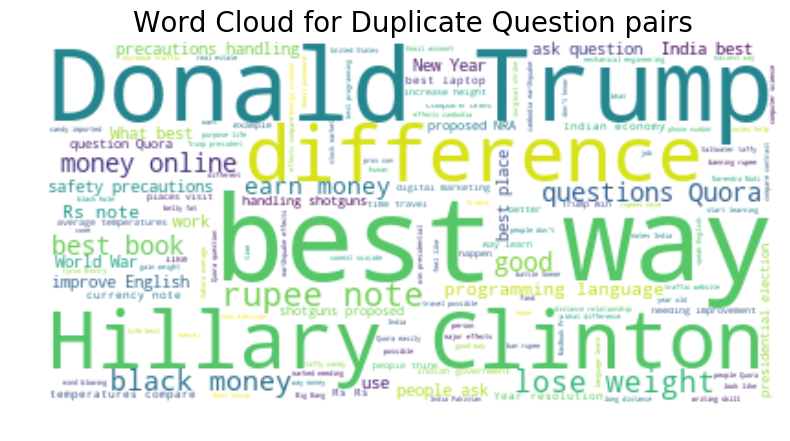

In [39]:
plt.figure(figsize=(8,8), dpi=100)
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
#print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Duplicate Question pairs", color='black', size=20)
plt.tight_layout()
plt.show()

### `2.Violinlot`

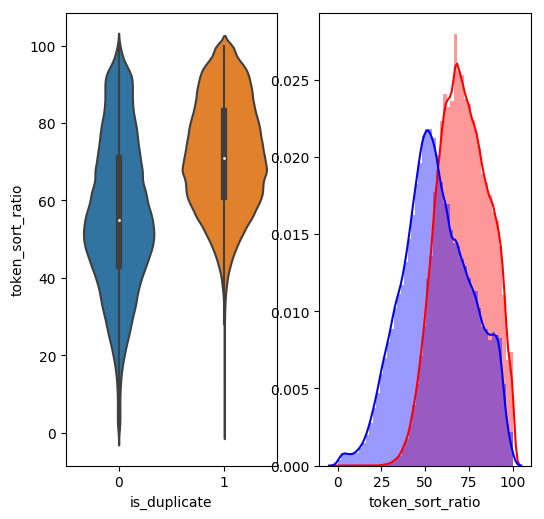

In [40]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(6, 6), dpi=100)

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

### `3.tSNE`

In [41]:
#Using TSNE for Dimentionality reduction for 14 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:500]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'first_word_eq' , 'abs_len_diff' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [42]:
from sklearn.manifold import TSNE
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.215459
[t-SNE] Computed conditional probabilities in 0.034s
[t-SNE] Iteration 50: error = 59.2758102, gradient norm = 0.5010622 (50 iterations in 0.384s)
[t-SNE] Iteration 100: error = 58.6526222, gradient norm = 0.4975067 (50 iterations in 0.381s)
[t-SNE] Iteration 150: error = 58.4290771, gradient norm = 0.5111917 (50 iterations in 0.375s)
[t-SNE] Iteration 200: error = 58.3918343, gradient norm = 0.4965278 (50 iterations in 0.372s)
[t-SNE] Iteration 250: error = 58.1947746, gradient norm = 0.4879106 (50 iterations in 0.377s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.194775
[t-SNE] Iteration 300: error = 0.5708505, gradient norm = 0.0015301 (50 iterations in 0.340s)
[t-SNE] Iteration 350: error = 0.5216662, gradient norm = 0.0005339 (

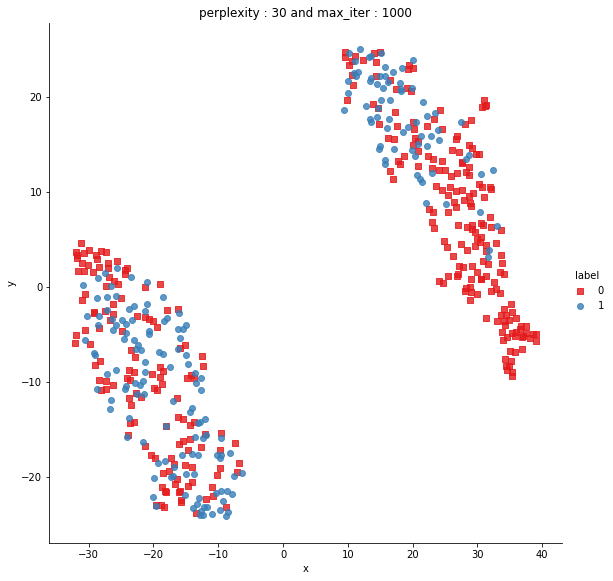

In [43]:
d = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=d, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

### `3.tSNE-3D`

In [44]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.215459
[t-SNE] Computed conditional probabilities in 0.033s
[t-SNE] Iteration 50: error = 66.8670273, gradient norm = 0.3592659 (50 iterations in 1.159s)
[t-SNE] Iteration 100: error = 73.1500702, gradient norm = 0.3126838 (50 iterations in 1.017s)
[t-SNE] Iteration 150: error = 78.8705215, gradient norm = 0.2922585 (50 iterations in 1.007s)
[t-SNE] Iteration 200: error = 87.0154343, gradient norm = 0.2738982 (50 iterations in 1.014s)
[t-SNE] Iteration 250: error = 87.6179962, gradient norm = 0.2592096 (50 iterations in 0.989s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.617996
[t-SNE] Iteration 300: error = 2.4458036, gradient norm = 0.0006620 (50 iterations in 1.145s)
[t-SNE] Iteration 350: error = 2.0095630, gradient norm = 0.0002913 (

In [45]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

# `Conclusion `




***`1. I have created functional approach in creation of some of the primary features of data frame`***

***`2. I have created SPACY in this project for stopwords, punctuation removal, token creation etc.`***

***`3. I have plotted heatmap in order to see the correlation amongst features`***